## Classification Project for "Python for Data Science" course

Project on Classification for "Python for Data Science" | Курсовой проект для курса "Библиотеки Python для Data Science: продолжение"

Data to be used | Материалы к проекту (файлы): <br>
* train.csv - the training set
* test.csv - the test set
* sampleSubmission.csv - a sample submission file in the correct format

Project Description | Задание : <br>
To predict the Credit Default in test.csv. You will be given two datasets: train.csv (contains all features and Credit Default) and test.csv (only features).<br> Используя данные из обучающего датасета (train.csv: содержит признаки и факт невыполнения кредитных обязательств), построить модель для предсказания факта невыполнения кредитных обязательств на тестовом датасете (test.csv: содержит только признаки).<br>


Target | Целевая переменная :<br>
Credit Default

Evaluation | Метрика качества :<br>
F1-Score metric which weights recall and precision equally

Требования к решению:<br>

## Import packages, modules and functions | Подключение библиотек и скриптов

In [1]:
 !pip install catboost

In [2]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score
import catboost as catb

from scipy.stats import chi2_contingency

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [8]:
def build_feature_by_target_graph(feature, target, data, graphName):
    plt.figure(figsize=(12, 8))
    title = ""

    if graphName == "countplot":
        sns.countplot(x=feature, hue=target, data=data)
        plt.title(f'{feature} grouped by {target}')
        plt.legend(title='Target', loc='upper right')
    elif graphName == "pointplot":
        sns.pointplot(x=target, y=feature, data=data[[feature, target]], capsize=.1)
        plt.title(f'Confidence intervals for {feature}')
    else:
        print(f'{graphName} is not defined in this function' )

    plt.show() 

In [9]:
def count_chi2_contingency(data, feature, target, value1, value2):
    feature_and_target = data.loc[data[feature].isin([value1, value2]), ['Id', feature, target]]
    table = feature_and_target.pivot_table(values='Id', index=feature, columns=target, aggfunc='count')
    chi2, p, _, _ = chi2_contingency(table)
    return p 

In [10]:
def outliers_missing_report(feature, data_train, data_test, outliers=None):
    print(f'Number of records with missing data on train for {feature} feature : {data_train[feature].isnull().sum()}')
    print(f'Number of records with missing data on test for {feature} feature : {data_test[feature].isnull().sum()}')
    if outliers:
        print(f'Number of records with outliers on train for {feature} feature : {data_train.loc[data_train[feature] > outliers, feature].count()}')
        print(f'Number of records with outliers on test for {feature} feature : {data_test.loc[data_test[feature] > outliers, feature].count()}')

**Set data path | Пути к директориям и файлам**

In [11]:
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'

**Data fields description | Описание датасета**

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Load dataset | Загрузка данных**

In [12]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [13]:
df_train = optimizing_df(df_train)
df_test = optimizing_df(df_test)

## Analyze data | Обзор данных<a class="anchor" id="review"></a>

In [14]:
df_train.shape[1]-1 == df_test.shape[1]

True

#### Observations: 
* Number of culumns are the same on train and test datasets

In [15]:
df_train.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0


In [16]:
df_test.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.700000,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


In [17]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

#### Observations: 
* Home Ownership, Years in current job, Purpose and Term are having alphabetical values
* Annual Income , Credit Score, Years in current job, Months since last delinquent have some NaN values

In [19]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


#### Observations: 
* CreditScore might have some outliers: it shows 7510 as Max, while 75% shows only 743
* Current Loan amount might have some outliers. Max is 100000000, 50% is 309573, mean is 11873135. 
* Maximum Open Credit amount might have some outliers, as Max is 1.304726e+09 which is too big to be true
* Months since last delinquent might have some outliers. as Max is 118, 50% 32, mean 34

### Analyze Target: Credit Default | Обзор целевой переменной**

In [20]:
TARGET_NAME = 'Credit Default'

In [21]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Observations: 
* There is a disbalance between 0 and 1 values. Might need to balance it

### Analyze Features | Обзор признаков

**Features available in the dataset:**

In [22]:
df_train.columns.values

array(['Home Ownership', 'Annual Income', 'Years in current job',
       'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'], dtype=object)

In [23]:
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

**Define numerical and categorical | Отбор признаков**

In [24]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [25]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

**Features that are numerical | Обзор количественных признаков**

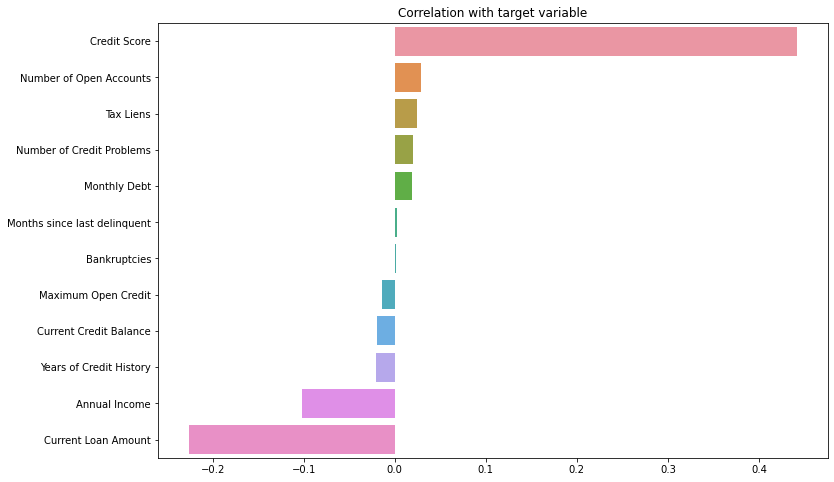

In [26]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(12, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Observations: 
* Credit Score, Current Loan Amont and Annual Income are have the biggest correlation with our target

**Analyze "Credit Score" feature | Оценка признака "Credit Score" в разрезе целевой переменной**

In [27]:
feature_name = 'Credit Score'

In [28]:
df_train[feature_name].isnull().sum()

1557

In [29]:
df_test[feature_name].isnull().sum()

513

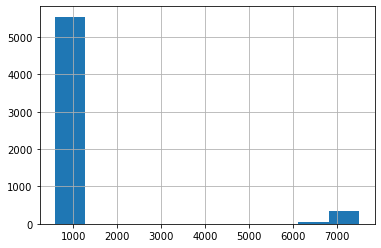

In [30]:
df_train[feature_name].hist();

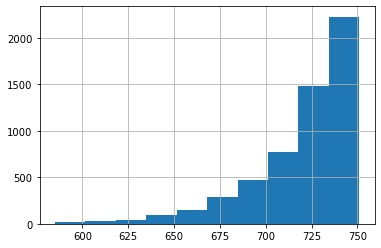

In [31]:
df_train.loc[df_train[feature_name] < 1000, feature_name].hist();

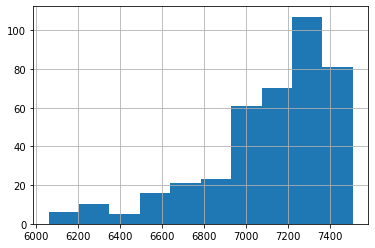

In [32]:
df_train.loc[df_train[feature_name] > 1000, feature_name].hist();

In [33]:
df_train.loc[df_train[feature_name] > 1000, feature_name].count()

400

#### Observations: 
* "Credit Score" has some missing values. In addition, it has a lot of outliers. But it seems like outliers are bigger that 6000. According to USA credit history, the max credit score can be 850. So, it might be a good idea to devide this values to 10. Both missing values and outliers have to be replaces

**Analyze "Current Loan Amount" feature | Оценка признака "Current Loan Amount" в разрезе целевой переменной**

In [34]:
feature_name = 'Current Loan Amount'

In [35]:
df_train[feature_name].isnull().sum()

0

In [36]:
df_test[feature_name].isnull().sum()

0

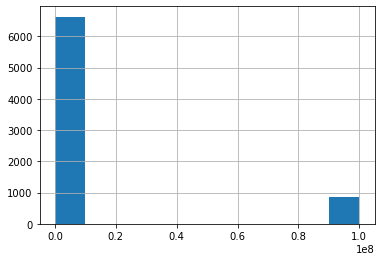

In [37]:
feature_name = feature_name
df_train[feature_name].hist();

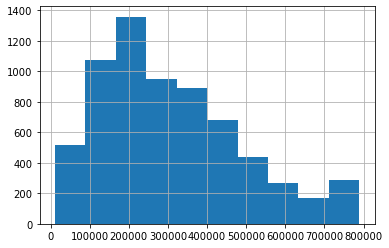

In [38]:
df_train.loc[df_train[feature_name] < 0.2e+8, feature_name].hist();

In [39]:
df_train.loc[df_train[feature_name] > 0.2e+8, feature_name].count()

870

#### Observations: 
* "Current Loan Amount" does not have any missing values. But, it has a lot of outliers (870)

**Analyze "Annual Income" feature | Оценка признака "Annual Income" в разрезе целевой переменной**

In [40]:
feature_name = 'Annual Income'

In [41]:
df_train[feature_name].isnull().sum()

1557

In [42]:
df_test[feature_name].isnull().sum()

513

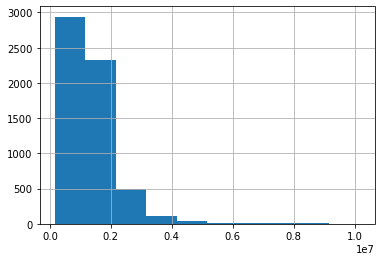

In [43]:
df_train[feature_name].hist();

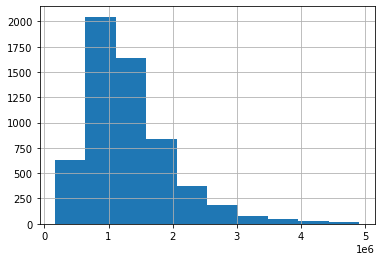

In [44]:
df_train.loc[df_train[feature_name] < 5e+6, feature_name].hist();

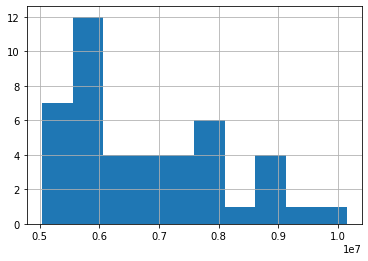

In [45]:
df_train.loc[df_train[feature_name] > 5e+6, feature_name].hist();

In [46]:
df_train.loc[df_train[feature_name] > 5e+6, feature_name].count()

44

#### Observations: 
* "Annual Income" has some missing values. In addition, it has a lot of outliers. Both missing values and outliers have to be replaces

**Features that are categorical: | Обзор номинативных признаков**

* **Home Ownership** - Home Mortgage, Rent, Own Home, Have Mortgage
* **Years in current job** - 10+, 9, 8, 7, 6, 5, 4, 3, 2, 1, < 1 year(s)
* **Purpose** - debt consolidation, other, home improvements, business loan, buy a car, medical bills, major purchase,  take a trip, buy house, small business, wedding, moving, educational expenses, vacation, renewable energy   
* **Term** - Short Term, Long Term

In [47]:
for cat_colname in df_train[CAT_FEATURE_NAMES].columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Analyze "Home Ownership" feature | Оценка признака "Home Ownership" в разрезе целевой переменной**

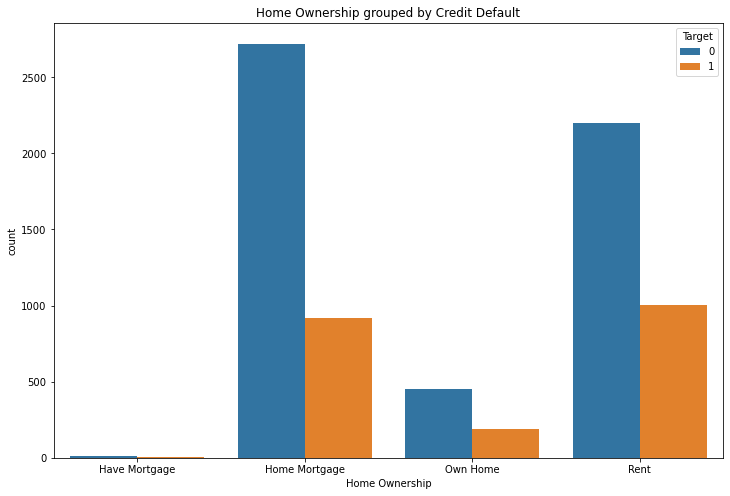

In [48]:
build_feature_by_target_graph("Home Ownership", TARGET_NAME, df_train, "countplot")

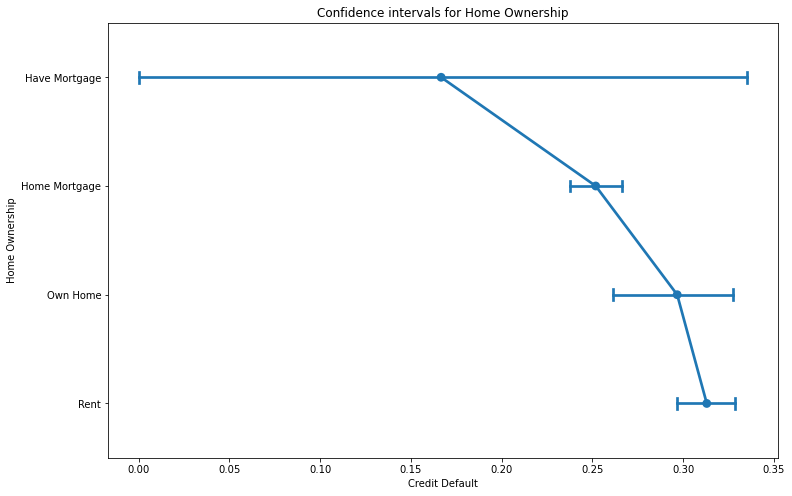

In [49]:
build_feature_by_target_graph("Home Ownership", TARGET_NAME, df_train, "pointplot")

#### Observations: 
* By looking at the grapth, it seems like there is no any parameters that can be grouped together

**Analyze "Years in current job" feature | Оценка признака "Years in current job" в разрезе целевой переменной**

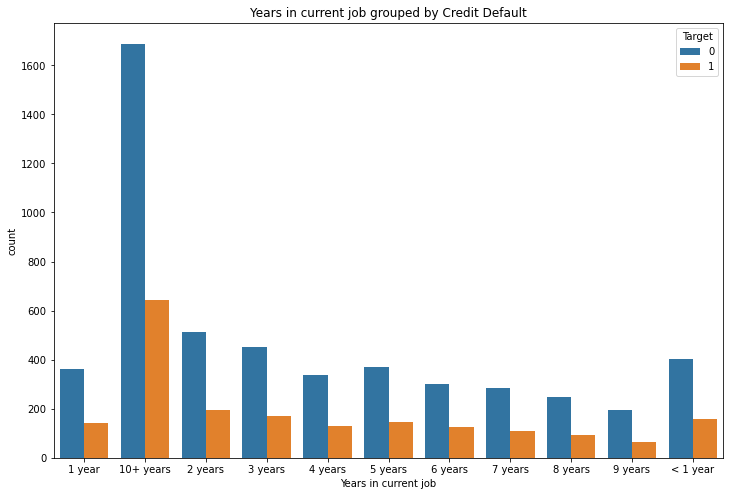

In [50]:
build_feature_by_target_graph("Years in current job", TARGET_NAME, df_train, "countplot")

#### Observations: 
* Years in current job can be transform to numeric value

**Analyze "Purpose" feature | Оценка признака "Purpose" в разрезе целевой переменной**

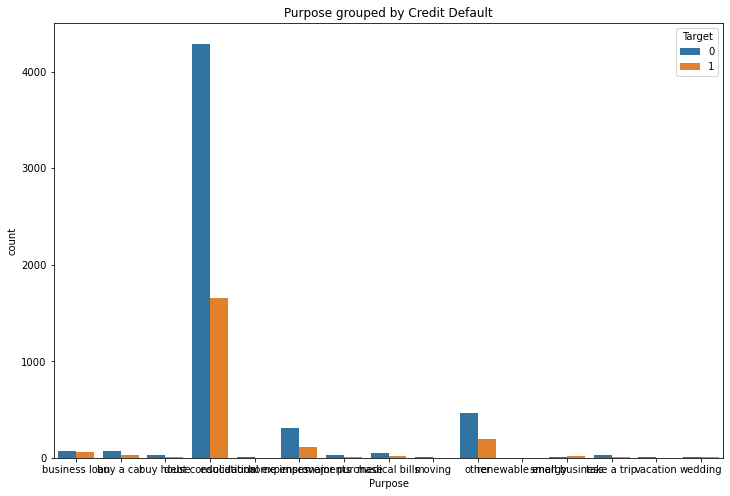

In [51]:
build_feature_by_target_graph("Purpose", TARGET_NAME, df_train, "countplot")

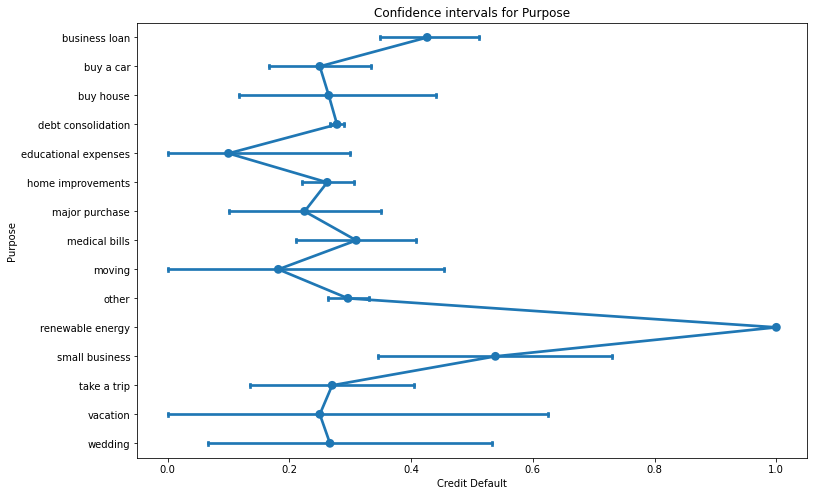

In [52]:
build_feature_by_target_graph("Purpose", TARGET_NAME, df_train, "pointplot")

#### Observations: 
* Some parameters like "major purchase", "buy house", "buy a car", "wedding", "moving" can be combined together

**Analyze "Term" feature | Оценка признака "Term" в разрезе целевой переменной**

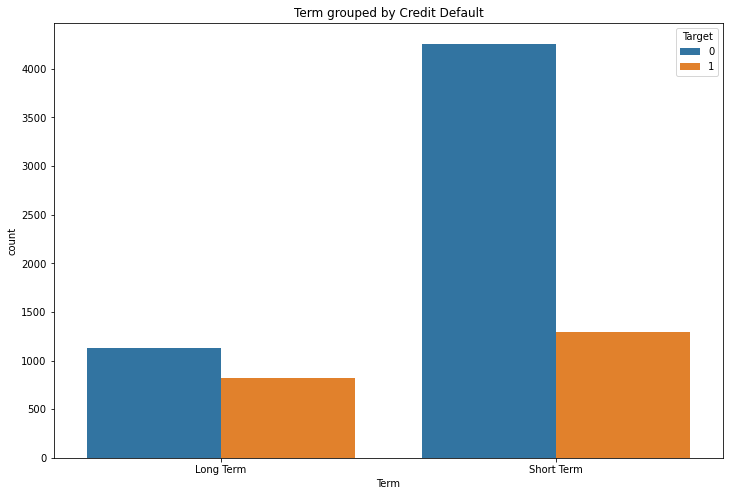

In [53]:
build_feature_by_target_graph("Term", TARGET_NAME, df_train, "countplot")

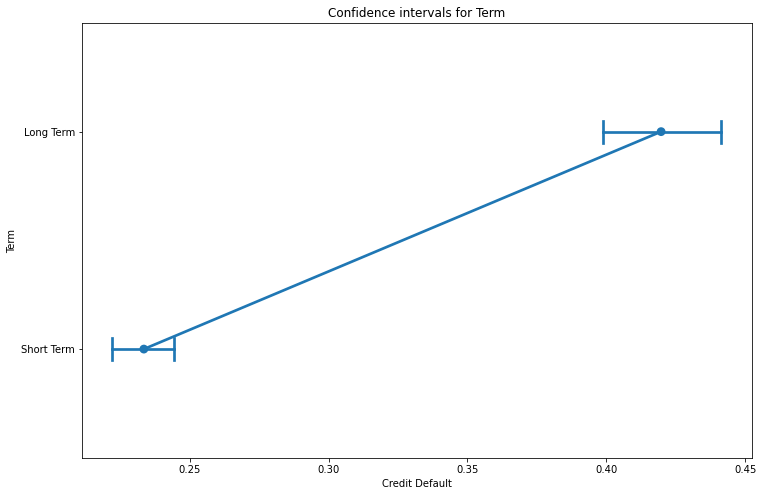

In [54]:
build_feature_by_target_graph("Term", TARGET_NAME, df_train, "pointplot")

#### Observations: 
* "long term" and "short term" can be chaged to binary

## Data processing | Предобработка данных

**Work with Outliers and missing data | Обработка пропусков выбросов**

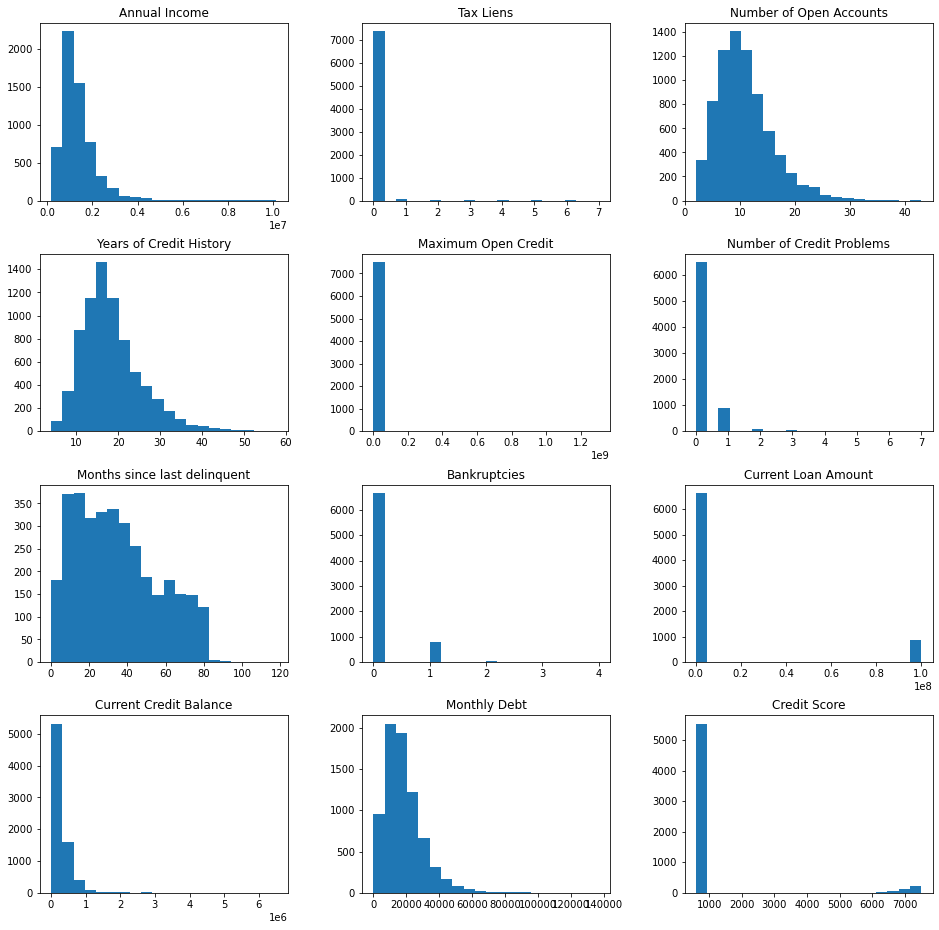

In [55]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

**Work with Outliers and missing data for "Annual Income" | Обработка пропусков выбросов**

In [56]:
outliers_missing_report("Annual Income", df_train, df_test, 4e+06)

Number of records with missing data on train for Annual Income feature : 1557
Number of records with missing data on test for Annual Income feature : 513
Number of records with outliers on train for Annual Income feature : 91
Number of records with outliers on test for Annual Income feature : 27


In [57]:
#df_train.loc[df_train["Annual Income"] > 4e+06, "Annual Income"] = np.nan
#df_test.loc[df_test["Annual Income"] > 4e+06, "Annual Income"] = np.nan

In [58]:
df_train.loc[df_train["Annual Income"].isnull(), 'Annual Income'] = df_train["Annual Income"].median()
df_test.loc[df_test["Annual Income"].isnull(), 'Annual Income'] = df_test["Annual Income"].median()

**Work with Outliers and missing data for "Tax Liens" | Обработка пропусков выбросов**

In [59]:
outliers_missing_report("Tax Liens", df_train, df_test, 0.1)

Number of records with missing data on train for Tax Liens feature : 0
Number of records with missing data on test for Tax Liens feature : 0
Number of records with outliers on train for Tax Liens feature : 134
Number of records with outliers on test for Tax Liens feature : 55


In [60]:
df_train.loc[df_train["Tax Liens"]> 0, "Tax Liens"] = 1
df_test.loc[df_test["Tax Liens"]> 0, "Tax Liens"] = 1

**Work with Outliers and missing data for "Number of Open Accounts" | Обработка пропусков выбросов**

In [61]:
outliers_missing_report("Number of Open Accounts", df_train, df_test, 30)

Number of records with missing data on train for Number of Open Accounts feature : 0
Number of records with missing data on test for Number of Open Accounts feature : 0
Number of records with outliers on train for Number of Open Accounts feature : 27
Number of records with outliers on test for Number of Open Accounts feature : 6


**Work with Outliers and missing data for "Years of Credit History" | Обработка пропусков выбросов**

In [62]:
outliers_missing_report("Years of Credit History", df_train, df_test, 50)

Number of records with missing data on train for Years of Credit History feature : 0
Number of records with missing data on test for Years of Credit History feature : 0
Number of records with outliers on train for Years of Credit History feature : 8
Number of records with outliers on test for Years of Credit History feature : 2


**Work with Outliers and missing data for "Maximum Open Credit" | Обработка пропусков выбросов**

In [63]:
outliers_missing_report("Maximum Open Credit", df_train, df_test, 3e+6)

Number of records with missing data on train for Maximum Open Credit feature : 0
Number of records with missing data on test for Maximum Open Credit feature : 0
Number of records with outliers on train for Maximum Open Credit feature : 98
Number of records with outliers on test for Maximum Open Credit feature : 38


In [64]:
#df_train.loc[df_train["Maximum Open Credit"]> 3e+6, "Maximum Open Credit"] = df_train["Maximum Open Credit"].median()
#df_test.loc[df_test["Maximum Open Credit"]> 3e+6, "Maximum Open Credit"] = df_test["Maximum Open Credit"].median()

**Work with Outliers and missing data for "Number of Credit Problems" | Обработка пропусков выбросов**

In [65]:
outliers_missing_report("Number of Credit Problems", df_train, df_test, 0.1)

Number of records with missing data on train for Number of Credit Problems feature : 0
Number of records with missing data on test for Number of Credit Problems feature : 0
Number of records with outliers on train for Number of Credit Problems feature : 1031
Number of records with outliers on test for Number of Credit Problems feature : 323


In [66]:
df_train.loc[df_train["Number of Credit Problems"]> 0, "Number of Credit Problems"] = 1
df_test.loc[df_test["Number of Credit Problems"]> 0, "Number of Credit Problems"] = 1

**Work with Outliers and missing data for "Months since last delinquent" | Обработка пропусков выбросов**

In [67]:
outliers_missing_report("Months since last delinquent", df_train, df_test, 80)

Number of records with missing data on train for Months since last delinquent feature : 4081
Number of records with missing data on test for Months since last delinquent feature : 1358
Number of records with outliers on train for Months since last delinquent feature : 31
Number of records with outliers on test for Months since last delinquent feature : 8


In [68]:
#df_train.loc[df_train["Months since last delinquent"]> 80, "Months since last delinquent"] = df_train["Months since last delinquent"].median()
#df_test.loc[df_test["Months since last delinquent"]> 80, "Months since last delinquent"] = df_test["Months since last delinquent"].median()

In [69]:
df_train.loc[df_train["Months since last delinquent"].isnull(), 'Months since last delinquent'] = 0
df_test.loc[df_test["Months since last delinquent"].isnull(), 'Months since last delinquent'] = 0

**Work with Outliers and missing data for "Bankruptcies" | Обработка пропусков выбросов**

In [70]:
outliers_missing_report("Bankruptcies", df_train, df_test, 0.1)

Number of records with missing data on train for Bankruptcies feature : 14
Number of records with missing data on test for Bankruptcies feature : 3
Number of records with outliers on train for Bankruptcies feature : 826
Number of records with outliers on test for Bankruptcies feature : 245


In [71]:
df_train.loc[df_train["Bankruptcies"].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test["Bankruptcies"].isnull(), 'Bankruptcies'] = 0

In [72]:
df_train.loc[df_train["Bankruptcies"]>0, 'Bankruptcies'] = 1
df_test.loc[df_test["Bankruptcies"]>0, 'Bankruptcies'] = 1

**Work with Outliers and missing data for "Current Loan Amount" | Обработка пропусков выбросов**

In [73]:
outliers_missing_report("Current Loan Amount", df_train, df_test, 0.2e+8)

Number of records with missing data on train for Current Loan Amount feature : 0
Number of records with missing data on test for Current Loan Amount feature : 0
Number of records with outliers on train for Current Loan Amount feature : 870
Number of records with outliers on test for Current Loan Amount feature : 297


In [74]:
#df_train.loc[df_train["Current Loan Amount"]>= 0.2e+8, "Current Loan Amount"] = df_train["Current Loan Amount"].median()
#df_test.loc[df_test["Current Loan Amount"]>= 0.2e+8, "Current Loan Amount"] = df_test["Current Loan Amount"].median()

**Work with Outliers and missing data for "Current Credit Balance" | Обработка пропусков выбросов**

In [75]:
outliers_missing_report("Current Credit Balance", df_train, df_test, 2e+6)

Number of records with missing data on train for Current Credit Balance feature : 0
Number of records with missing data on test for Current Credit Balance feature : 0
Number of records with outliers on train for Current Credit Balance feature : 41
Number of records with outliers on test for Current Credit Balance feature : 20


In [76]:
df_train.loc[df_train["Current Credit Balance"]> 2e+6, 'Current Credit Balance'] = 2e+6
df_test.loc[df_test["Current Credit Balance"]> 2e+6, 'Current Credit Balance'] = 2e+6

**Work with Outliers and missing data for "Monthly Debt" | Обработка пропусков выбросов**

In [77]:
outliers_missing_report("Monthly Debt", df_train, df_test, 70000)

Number of records with missing data on train for Monthly Debt feature : 0
Number of records with missing data on test for Monthly Debt feature : 0
Number of records with outliers on train for Monthly Debt feature : 30
Number of records with outliers on test for Monthly Debt feature : 8


In [78]:
df_train.loc[df_train["Monthly Debt"]> 70000, 'Monthly Debt'] = df_train["Monthly Debt"].median()
df_test.loc[df_test["Monthly Debt"]> 70000, 'Monthly Debt'] = df_test["Monthly Debt"].median()

**Work with Outliers and missing data for "Credit Score" | Обработка пропусков выбросов**

In [79]:
outliers_missing_report("Credit Score", df_train, df_test, 750)

Number of records with missing data on train for Credit Score feature : 1557
Number of records with missing data on test for Credit Score feature : 513
Number of records with outliers on train for Credit Score feature : 460
Number of records with outliers on test for Credit Score feature : 177


In [80]:
df_train.loc[df_train["Credit Score"]> 6000, 'Credit Score'] = 0
df_test.loc[df_test["Credit Score"]> 6000, 'Credit Score'] = 0

In [81]:
df_train.loc[df_train["Credit Score"].isnull(), 'Credit Score'] = df_train["Credit Score"].median()
df_test.loc[df_test["Credit Score"].isnull(), 'Credit Score'] = df_test["Credit Score"].median()

**Work with Outliers and missing data for "Home Ownership" | Обработка пропусков выбросов**

In [82]:
outliers_missing_report("Home Ownership", df_train, df_test)

Number of records with missing data on train for Home Ownership feature : 0
Number of records with missing data on test for Home Ownership feature : 0


**Work with Outliers and missing data for "Years in current job" | Обработка пропусков выбросов**

In [83]:
outliers_missing_report("Years in current job", df_train, df_test)

Number of records with missing data on train for Years in current job feature : 371
Number of records with missing data on test for Years in current job feature : 86


In [84]:
df_train.loc[df_train["Years in current job"].isnull(), 'Years in current job'] = df_train["Years in current job"].mode()[0]
df_test.loc[df_test["Years in current job"].isnull(), 'Years in current job'] = df_test["Years in current job"].mode()[0]

In [85]:
df_train['Years in current job'] = df_train['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
df_test['Years in current job'] = df_test['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})

**Work with Outliers and missing data for "Purpose" | Обработка пропусков выбросов**

In [86]:
outliers_missing_report("Purpose", df_train, df_test)

Number of records with missing data on train for Purpose feature : 0
Number of records with missing data on test for Purpose feature : 0


**Work with Outliers and missing data for "Term" | Обработка пропусков выбросов**


In [87]:
outliers_missing_report("Term", df_train, df_test)

Number of records with missing data on train for Term feature : 0
Number of records with missing data on test for Term feature : 0


In [88]:
df_train['Term'] = df_train['Term'].replace({'Short Term':0, 'Long Term':1})
df_test['Term'] = df_test['Term'].replace({'Short Term':0, 'Long Term':1})

### Set Train and Test | Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [89]:
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME, "Months since last delinquent").tolist()

In [90]:
CAT_FEATURE_NAMES = ['Home Ownership', "Years in current job", 'Purpose', 'Term']

In [91]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [92]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

### Final Model | Финальная модель

In [98]:
%%time

final_model = catb.CatBoostClassifier(silent=True, 
                                      random_state=42,
                                      class_weights=[1, disbalance],
                                      eval_metric='F1',
                                      cat_features=CAT_FEATURE_NAMES,
                                      early_stopping_rounds=50,
                                      use_best_model=True,
                                      iterations=200, 
                                      depth=5, 
                                      reg_lambda=0.5,
                                      custom_metric=['Precision', 'Recall']
                                    )
    
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3771
           1       0.52      0.61      0.56      1479

    accuracy                           0.73      5250
   macro avg       0.68      0.70      0.69      5250
weighted avg       0.75      0.73      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1616
           1       0.51      0.63      0.56       634

    accuracy                           0.73      2250
   macro avg       0.68      0.70      0.68      2250
weighted avg       0.75      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1237  379
1                237  397
CPU times: user 1.47 s, sys: 106 ms, total: 1.57 s
Wall time: 1.03 s


### Feature importance | Важность признаков

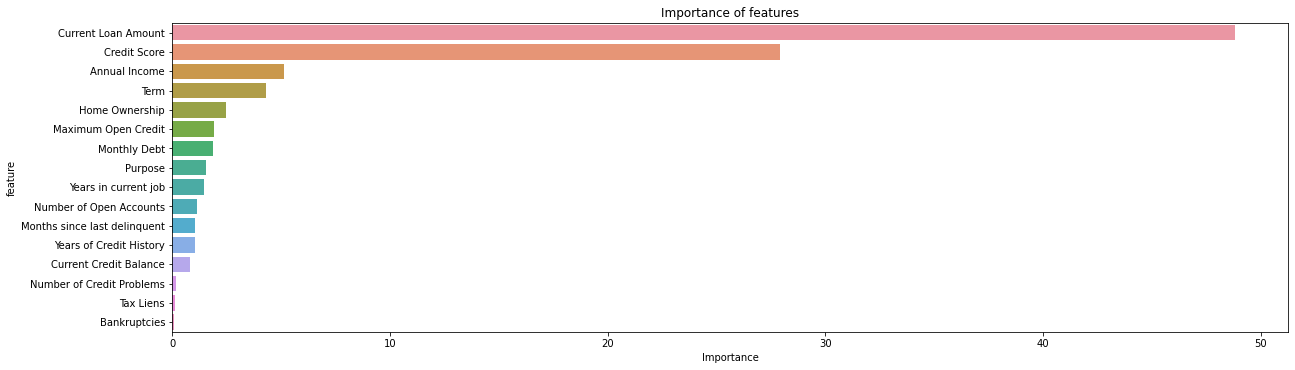

In [94]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=23)

### Results | Сохранение финальной модели

In [95]:
df_test[TARGET_NAME] = final_model.predict(df_test[BASE_FEATURE_NAMES])

In [96]:
df_test[TARGET_NAME]

0       0
1       1
2       1
3       0
4       0
       ..
2495    0
2496    0
2497    1
2498    0
2499    1
Name: Credit Default, Length: 2500, dtype: int64

In [97]:
df_test['Id'] = df_test.index
df_test[['Id', TARGET_NAME]].to_csv('AStrunova_predictions.csv', index=None)